# Transaction Fraud detection

# Набор данных Banksim
Мы выявляем мошеннические транзакции из набора данных Banksim. 
Этот синтетически созданный набор данных состоит из платежей от разных клиентов, произведенных в
разные периоды времени и с разными суммами. 

# Описание колонок
* Step: Означает день со старта симуляции (максимум 180, т.е примерно 6 месяцев).
* Customer: Идентификатор покупателя
* zipCodeOrigin: ZIP код покупателя
* Merchant: Идентификатор продавца
* zipMerchant: ZIP код продавца
* Age: категоризованный возраст
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46-55,
5: 56-65,
6: > 65
U: Неизвестно (Unknown)
* Gender: Gender for customer
E: Компания (Enterprise),
F: Женский (Female),
M: Мужской (Male,
U: Неизвестно (Unknown)
* Category: Категория покупки
* Amount: Объем транзакции
* Fraud: 1 (fraud, мошенничество), 0 (обычная транзакция)

Задание

1) Проведите первичный анализ данных, сформулируйте эвристики для детекции фрода (аномалий), которые можно использовать в качестве базового решения. Приведите метрики качества для оценки вашего алгоритма.

2) Попробуйте получить решение лучше по метрикам (с помощью модели ML), чем эвристика, помните, что класс 1 (мошенничество) в целом скорее важнее, чем класс 0.

3) Изучите одну из техник балансировки выборки (например, оверсемплинг с помощью метода SMOTE) и попробуйте еще улучшить качество алгоритма.

4) Выберите лучший алгоритм по пунктам 1-2-3 и внесите часть тестовой выборки (с предсказанием) в вашу учебную базу, а затем постройте дэшборд в redash в котором будет отражена информация о количестве фродовых транзакций за неделю, а также будут выведены последние 10 фродовых транзакций, требующих проверки.


https://sato-1.ru/pediatric-otolaryngologists/vysokoe-kolichestvo-froda-chto-takoe-frod-v-mobilnoi-reklame/

https://www.kaggle.com/code/turkayavci/fraud-detection-on-bank-payments

In [326]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
df=pd.read_csv('bs140513_032310.csv',quotechar="'", quoting=csv.QUOTE_NONNUMERIC)
df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0.0,C1093826151,4,M,28007.0,M348934600,28007.0,es_transportation,4.55,0.0
1,0.0,C352968107,2,M,28007.0,M348934600,28007.0,es_transportation,39.68,0.0
2,0.0,C2054744914,4,F,28007.0,M1823072687,28007.0,es_transportation,26.89,0.0
3,0.0,C1760612790,3,M,28007.0,M348934600,28007.0,es_transportation,17.25,0.0
4,0.0,C757503768,5,M,28007.0,M348934600,28007.0,es_transportation,35.72,0.0


## Первичный анализ

#### Вспомогательные функции

##### Функция зависимости фрод трансакций к общему количеству трансакций для категории, передаваемой в параметрах

In [387]:
def get_fraud_perc(column, df, df_fraud, ascending = False):
    df_fraud = df_fraud[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_all = df[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_perc = df_fraud.merge(df_all, on = column, suffixes=('_', '_all'))
    df_perc['perc'] = df_perc.fraud_ / df_perc.fraud_all *100
    return df_perc.sort_values(by='perc',  ascending = ascending)

##### Функция для графиков

In [403]:
def make_bar_plot(title, x, y,xlabel,ylabel, color = 'navy'):
    plt.figure(figsize=(15,7))
    plt.style.use('ggplot')
    plt.bar(x, y, color= color)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.title(title)
    plt.show()

def make_barh_plot(title, x, y,xlabel, ylabel, color = 'navy', figsize=(20,7)):
    plt.figure(figsize=figsize)
#     plt.style.use('ggplot')
    plt.barh(x, y, color= color)
    plt.title(title)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)
    plt.show()

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   step      594643 non-null  float64 
 1   customer  594643 non-null  object  
 2   age       594643 non-null  object  
 3   gender    594643 non-null  object  
 4   merchant  594643 non-null  object  
 5   category  594643 non-null  object  
 6   amount    594643 non-null  float64 
 7   fraud     594643 non-null  float64 
 8   new       594363 non-null  category
dtypes: category(1), float64(3), object(5)
memory usage: 36.9+ MB


In [296]:
df.isnull().sum()

step          0
customer      0
age           0
gender        0
merchant      0
category      0
amount        0
fraud         0
new         280
dtype: int64

In [217]:
df_fraud = df[df.fraud == 1]
df_nonfraud = df[df.fraud == 0]

Количество фрод операций значительно меньше, чем нефрод, то есть выборка ожидаемо несбалансированная


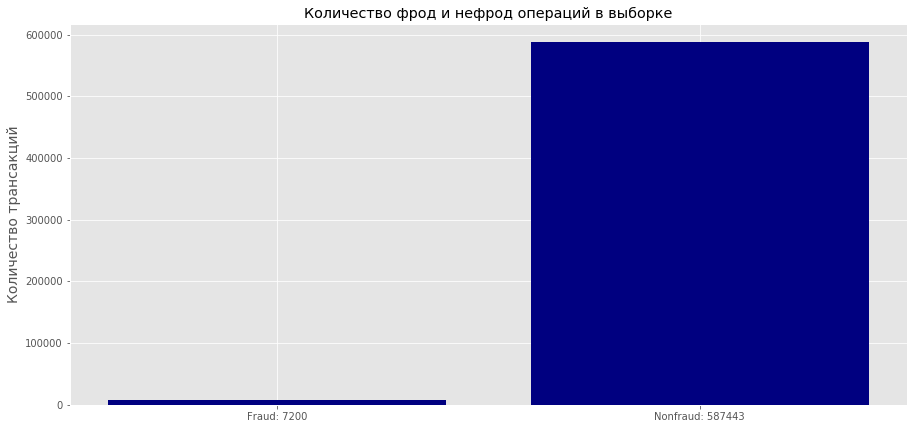

Отношение фрод трансакций к общему числу трансакций: 1.21%


In [380]:
x = [f'Fraud: {len(df_fraud)}', f'Nonfraud: {len(df_nonfraud)}']
y = [len(df_fraud), len(df_nonfraud)]
make_bar_plot("Количество фрод и нефрод операций в выборке", x, y, "", "Количество трансакций")

print(f'Отношение фрод трансакций к общему числу трансакций: {round(len(df_fraud)/len(df)*100, 2)}%', )

#### Зависимость от категории трат.
Мы видим, что в таких категориях как es_contents, es_food, es_transportation нет ни одной фрод трансакци.
Наиболее скомпромитированные категории в абсолютном значении- это es_sportsandtoys и es_health

In [381]:

df_cat = df[['category', 'fraud']].groupby(['category']).sum().sort_values(by=['fraud'])
df_cat

,fraud
category,
es_contents,0.0
es_food,0.0
es_transportation,0.0
es_fashion,116.0
es_barsandrestaurants,120.0
es_tech,158.0
es_otherservices,228.0
es_hyper,280.0
es_home,302.0


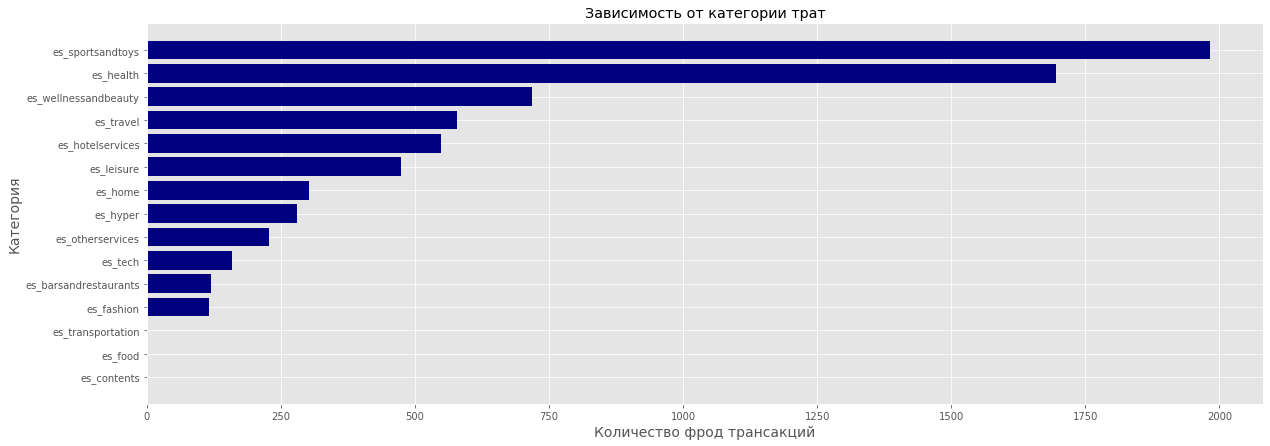

In [383]:
make_barh_plot("Зависимость от категории трат", df_cat.index, df_cat.fraud, "Количество фрод трансакций", "Категория")


Если  берем количество фрод трансакций в каждой категории трат по отношению 
ко всему объему в категориях, то получаются такие результаты:
В категориях es_fashion, es_barsandrestaurants, es_hyper, es_wellnessandbeauty и es_tech меньше 7 %
В категориях  es_leisure почти все трансакции фродовые, в категории es_travel - большинство

In [388]:
df_cat_ = get_fraud_perc('category', df, df_fraud, True)
df_cat_

,fraud_,fraud_all,perc
category,,,
es_fashion,116,6454,1.797335
es_barsandrestaurants,120,6373,1.882944
es_hyper,280,6098,4.591669
es_wellnessandbeauty,718,15086,4.759380
es_tech,158,2370,6.666667
es_health,1696,16133,10.512614
es_home,302,1986,15.206445
es_otherservices,228,912,25.000000
es_hotelservices,548,1744,31.422018


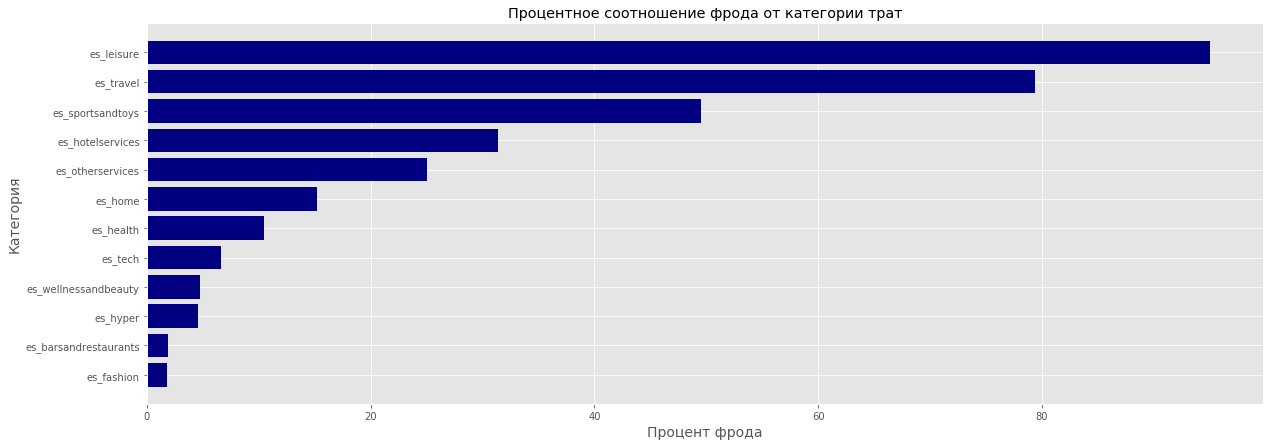

In [390]:
make_barh_plot("Процентное соотношение фрода от категории трат", 
               df_cat_.index, 
               df_cat_.perc,
               "Процент фрода",
               "Категория")


#### Зависимость размера  трат

Максимальный объема нефрод единовременной трансакции составляет 2144.86.
То есть, если мы обнаруживаем у клиента больший объем единовременной трансакции,то это будет скорее всего фрод-трансакция.
Все нулевые трансакции - не фрод.

Разделим фрейм согласно объему трансакций на части от 0 до 2500 с шагом 500. Рассмотрим, какой объем фрод операций в каждой части. Обнаружим, что основной объем трансакций лежит в диапазоне до 1000 уе. Большинство  трансакций больше 750 уе - фрод трансакции. В диапазоне от 500 до 700 трансакций размер фрод трансакций в два раза больше нефрод 

In [83]:
df_fraud.sort_values(by=['amount'], ascending = False)

,step,customer,age,gender,merchant,category,amount,fraud
513394,158.0,C702798720,2,M,M732195782,es_travel,8329.96,1.0
135692,48.0,C806399525,2,F,M732195782,es_travel,7665.56,1.0
383889,122.0,C1007572087,2,F,M732195782,es_travel,7635.41,1.0
6710,2.0,C375144053,6,F,M732195782,es_travel,7432.48,1.0
329533,107.0,C430880678,2,M,M2080407379,es_travel,7403.44,1.0
...,...,...,...,...,...,...,...,...
300857,98.0,C1211514218,3,M,M923029380,es_home,0.19,1.0
474050,147.0,C23049140,5,F,M1198415165,es_wellnessandbeauty,0.11,1.0
250816,84.0,C2088631865,3,F,M1198415165,es_wellnessandbeauty,0.10,1.0
297694,97.0,C1647495093,3,M,M1748431652,es_wellnessandbeauty,0.04,1.0


In [84]:
df_nonfraud.sort_values(by=['amount'], ascending = False)

,step,customer,age,gender,merchant,category,amount,fraud
11735,4.0,C2110568911,2,F,M732195782,es_travel,2144.86,0.0
1697,0.0,C210584188,4,M,M732195782,es_travel,1993.68,0.0
170847,59.0,C1920498287,2,M,M732195782,es_travel,1954.73,0.0
185565,64.0,C232299558,3,F,M732195782,es_travel,1953.05,0.0
114080,41.0,C536412201,2,M,M495352832,es_travel,1805.59,0.0
...,...,...,...,...,...,...,...,...
236075,79.0,C1890250226,3,M,M348934600,es_transportation,0.00,0.0
449213,140.0,C1372042334,1,F,M348934600,es_transportation,0.00,0.0
365584,117.0,C1710930627,2,F,M1823072687,es_transportation,0.00,0.0
136697,48.0,C1812702959,3,F,M1823072687,es_transportation,0.00,0.0


In [365]:
amount = ['0-250', '250-500','500-750', '750-1000','1000-1500', '1500-2000']
df_amount_fraud = df_fraud.copy()
df_amount_fraud['chunk'] = pd.cut(df_amount_fraud.amount, [0, 250, 500, 750, 1000,1500, 2000], 
                           labels=amount,
                           right=False, 
                           include_lowest=True)
df_amount_all = df.copy()
df_amount_all['chunk'] = pd.cut(df_amount_all.amount, [0, 250, 500, 750, 1000,1500, 2000], 
                           labels=amount,
                           right=False, 
                           include_lowest=True)


In [372]:
df_amount = get_fraud_perc('chunk', df_amount_all, df_amount_fraud).sort_values(by='chunk')


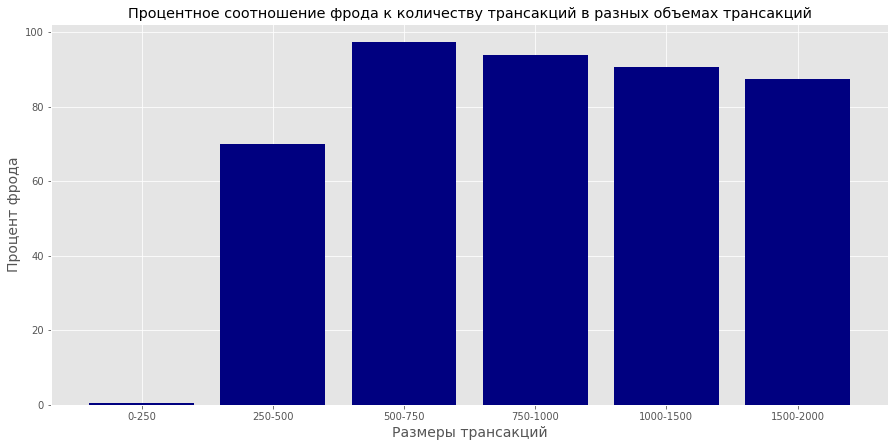

In [395]:
make_bar_plot("Процентное соотношение фрода к количеству трансакций в разных объемах трансакций",
              df_amount.index,
              df_amount.perc,
              "Размеры трансакций",
              "Процент фрода")


#### Зависимость от возраста

В абсолютном значении наиболее часто встечается фрод операции в возрастной категории 2: 26-35 лет.
Но если посчитать процентное соотношение всех трансакций в каждой категории к количеству фрода, то получается, что больший процента в возрасте  <= 18. 
В целом, этот параметр не очень информативный, тк даже в категории "до 18" процентное соотношение фрода - всего ок. 2%

In [247]:
df_age = get_fraud_perc('age', df, df_fraud)
df_age

,fraud_a,fraud_all,perc
age,,,
U,7,1178,0.594228
6,261,26774,0.974826
5,686,62642,1.095112
1,689,58131,1.185254
3,1755,147131,1.192815
2,2344,187310,1.251401
4,1410,109025,1.293281
0,48,2452,1.957586


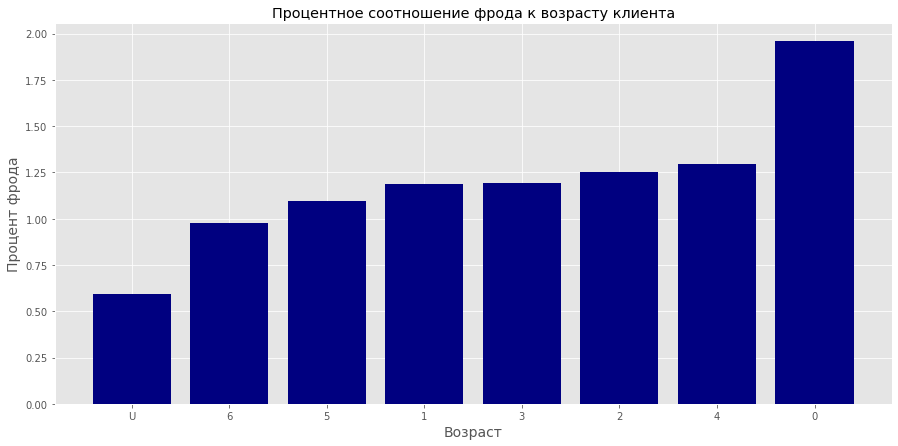

In [400]:
make_bar_plot("Процентное соотношение фрода к возрасту клиента", 
              df_age.index, 
              df_age.perc,
              "Возраст",
              "Процент фрода")


#### Зависимость от пола
Количество фрод трансакций у категории  E: Компания (Enterprise) в абсолютном и процентном соотношении пренебрежимо невелика. 

В остальном этот параметр также как и возраст не очень информативный

In [249]:
df_gender = get_fraud_perc('gender', df, df_fraud)
df_gender

,fraud_a,fraud_all,perc
gender,,,
E,7,1178,0.594228
M,2435,268385,0.907279
F,4758,324565,1.465962


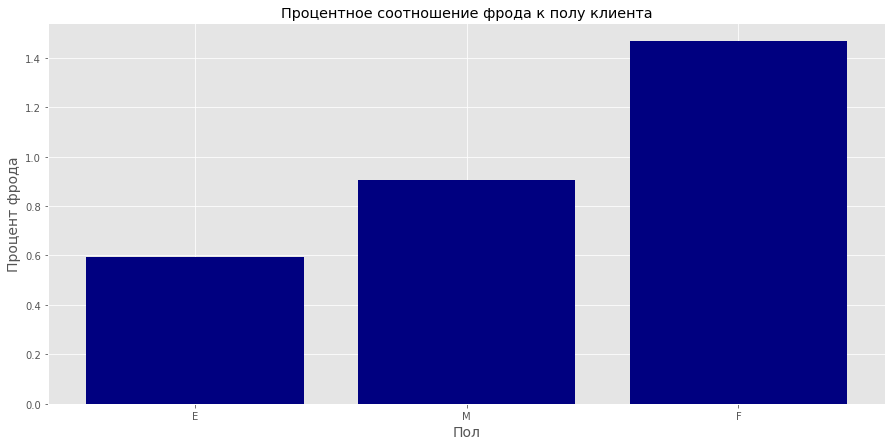

In [401]:
make_bar_plot("Процентное соотношение фрода к полу клиента", 
              df_gender.index, 
              df_gender.perc,
              "Пол",
              "Процент фрода")

#### Зависимость от продавца

Если посмотреть на продавцов и отношение всех трансакций к количеству фрода, то есть те продавцы, трансакции к которым практически все являются фродом, а также есть те, у которых они минимальны.

In [408]:
df_merch = get_fraud_perc('merchant', df, df_fraud, True)
df_merch

,fraud_,fraud_all,perc
merchant,,,
M692898500,16,900,1.777778
M151143676,120,6373,1.882944
M78078399,44,1608,2.736318
M209847108,106,3814,2.779234
M855959430,280,6098,4.591669
M50039827,46,916,5.021834
M1535107174,174,1868,9.314775
M348875670,10,107,9.345794
M1649169323,124,1173,10.571185


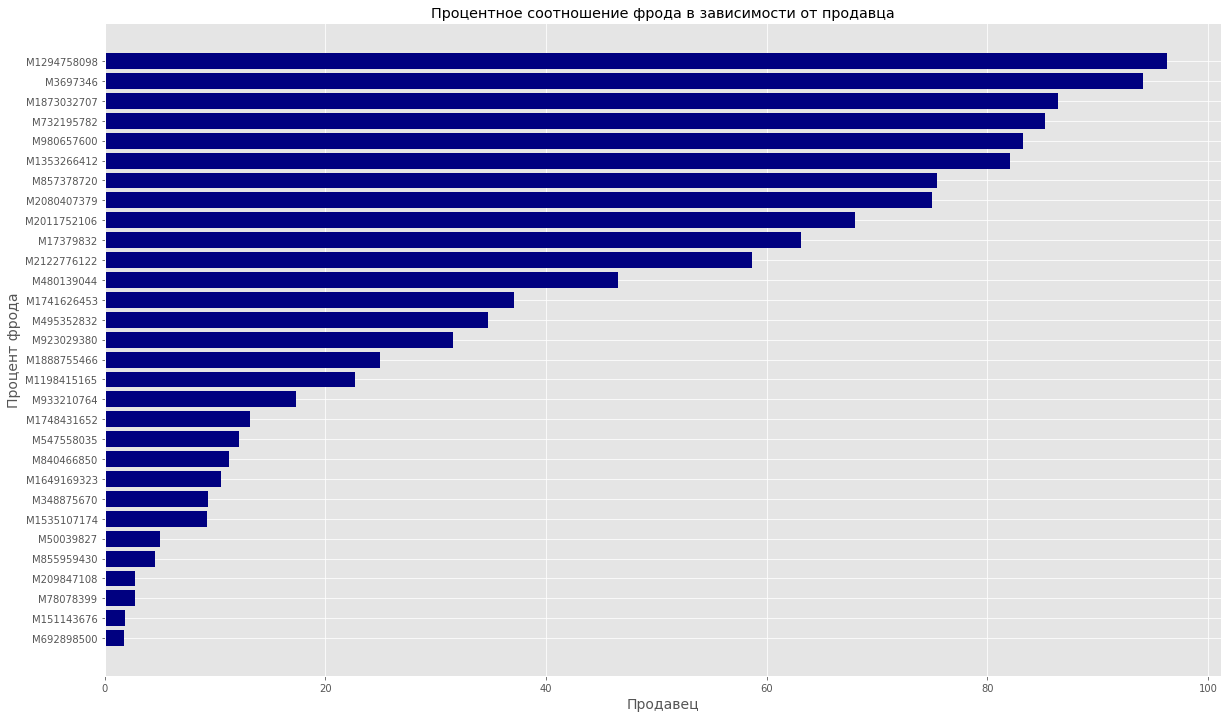

In [409]:
make_barh_plot("Процентное соотношение фрода в зависимости от продавца", 
              df_merch.index, 
              df_merch.perc,
              "Продавец",
              "Процент фрода",
               figsize = (20,12))

#### Зависимость от клиента
Если посмотреть на клиентов и отношение всех трансакций к количеству фрода, то есть те клиенты, трансакции к которым практически все являются фродом, а также есть те, к которых они минимальны.

In [410]:
df_cust = get_fraud_perc('customer', df, df_fraud, True)
df_cust

,fraud_,fraud_all,perc
customer,,,
C2120296918,1,187,0.534759
C1882101149,1,184,0.543478
C44857022,1,184,0.543478
C951689990,1,184,0.543478
C1307916597,1,183,0.546448
...,...,...,...
C617723960,40,46,86.956522
C1572610482,89,101,88.118812
C381007057,89,100,89.000000


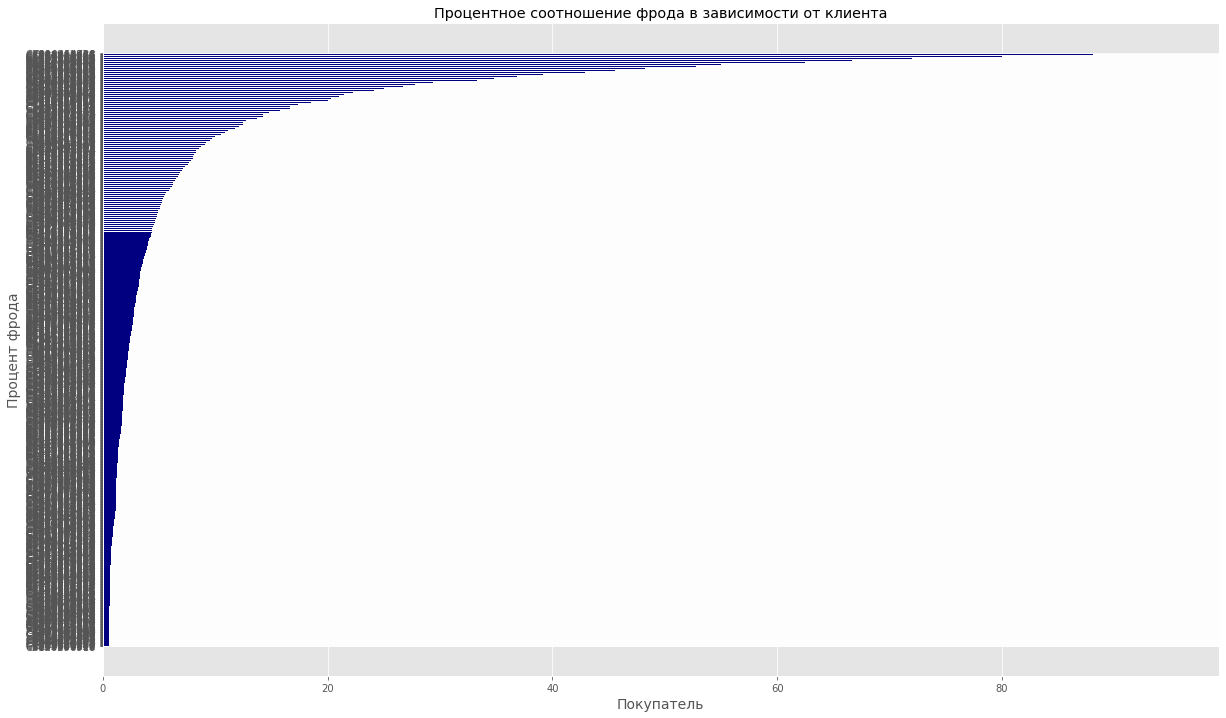

In [411]:
make_barh_plot("Процентное соотношение фрода в зависимости от клиента", 
              df_cust.index, 
              df_cust.perc,
              "Покупатель",
              "Процент фрода",
               figsize = (20,12))

#### Зависимость от дня
Предполагала, что возможно есть дни, в которых есть всплески фрод активностей. Но в этих синтетичесих данных каждый день случается 40 фрод трансакций

In [262]:
df_step = get_fraud_perc('step', df, df_fraud)
df_step.fraud_.unique()

array([40])

## Базовое решение

In [116]:
df_basic = df.copy()
df_basic['fraud'] = 0

In [109]:
#Тем трансакциям, в которых объем трансакций больше 2144.86, задаем значение 1(fraud)

In [118]:
df_basic.loc[df_basic['amount'] > 2144.86, 'fraud'] = 1

,step,customer,age,gender,merchant,category,amount,fraud
12,0.0,C623601481,3,M,M50039827,es_health,68.79,0
40,0.0,C1425441042,2,M,M1888755466,es_otherservices,87.67,0
42,0.0,C1635613216,4,F,M1053599405,es_health,105.59,0
79,0.0,C118437987,2,M,M1053599405,es_health,159.92,0
88,0.0,C583110837,3,M,M480139044,es_health,44.26,0
...,...,...,...,...,...,...,...,...
594624,179.0,C882083718,3,M,M349281107,es_fashion,71.83,0
594625,179.0,C882083718,3,M,M1600850729,es_fashion,26.48,0
594632,179.0,C1039390058,4,M,M1352454843,es_hotelservices,224.81,0
594633,179.0,C1039390058,4,M,M45060432,es_hotelservices,190.31,0


In [101]:
#Отсеиваем es_contents, es_food, es_transportation, в них нет фрода(Из 594643 строки осталось 62385)

In [117]:
df_basic = df_basic[~df_basic['category'].isin(['es_contents', 'es_food', 'es_transportation'] )]
# !!!!!!Может нужно не отсеивать, а в самом конце задать этим категориям значение 1 по умолчани.

## Preprocessing

В качестве target используется колонка fraud. Она бинарная, поэтому буду использовать ее без изменения

In [6]:
# В данной выборке все значения столбца zipcodeOri и zipMerchant = 28007.
# Поэтому можем избавиться от них
print(df.zipcodeOri.unique())
print(df.zipMerchant.unique()
     )

[28007.]
[28007.]


In [7]:
df.drop(['zipMerchant', 'zipcodeOri'], axis=1, inplace=True)

In [ ]:
# Преобразуем gender, age в числовое значение
df.loc[df['age'] == 'U', 'age'] = '7' 
df['age'] = df.age.astype(int)

# M: Мужской (Male) = 0
# F: Женский (Female) = 1
# E: Компания (Enterprise) = 2, 
# U: Неизвестно (Unknown) = 3
df.loc[df['gender'] == 'M', 'gender'] = 0
df.loc[df['gender'] == 'F', 'gender'] = 1
df.loc[df['gender'] == 'E', 'gender'] = 2
df.loc[df['gender'] == 'U', 'gender'] = 3

df['gender'] = df.gender.astype(int)

In [ ]:
df.info()

In [19]:
RANDOM_STATE = 777
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [20]:
y_train = df_train['fraud']
y_test = df_test['fraud']

In [9]:
task = Task(name='binary' ) # здесь задается тип решаемой задачи
roles = {'target': 'fraud'} # здесь задается название целевого признака 
automl = TabularAutoML(task=task, timeout=3600, memory_limit=10) # здесь создаем объект черной коробки LightAutoML
oof_pred = automl.fit_predict(df_train, roles=roles)

In [13]:
df

,step,customer,age,gender,merchant,category,amount,fraud
0,0.0,C1093826151,4,M,M348934600,es_transportation,4.55,0.0
1,0.0,C352968107,2,M,M348934600,es_transportation,39.68,0.0
2,0.0,C2054744914,4,F,M1823072687,es_transportation,26.89,0.0
3,0.0,C1760612790,3,M,M348934600,es_transportation,17.25,0.0
4,0.0,C757503768,5,M,M348934600,es_transportation,35.72,0.0
...,...,...,...,...,...,...,...,...
594638,179.0,C1753498738,3,F,M1823072687,es_transportation,20.53,0.0
594639,179.0,C650108285,4,F,M1823072687,es_transportation,50.73,0.0
594640,179.0,C123623130,2,F,M349281107,es_fashion,22.44,0.0
594641,179.0,C1499363341,5,M,M1823072687,es_transportation,14.46,0.0


In [21]:
df_test = df_test.drop('fraud',axis=1)
df_train = df_train.drop('fraud',axis=1)

Gini_train: 0.9984841221014302
Gini_test: 0.9975711910618583


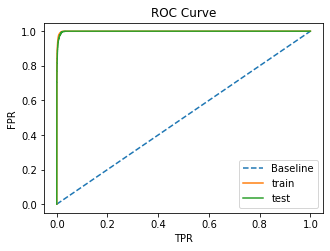

In [22]:
import matplotlib.pyplot as plt


y_train_score = automl.predict(df_train).data
y_test_score = automl.predict(df_test).data

print('Gini_train:', 2*roc_auc_score(y_train, y_train_score)-1)
print('Gini_test:', 2*roc_auc_score(y_test, y_test_score)-1)

curve1 = roc_curve(y_train, y_train_score)
curve2 = roc_curve(y_test, y_test_score)

plt.figure(figsize=(5, 3.5))
plt.plot([0, 1], label="Baseline", linestyle='--')
plt.plot(curve1[0], curve1[1], label='train')
plt.plot(curve2[0], curve2[1], label='test')
plt.title('ROC Curve')
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.legend(loc = 4)
plt.show();


In [23]:
automl.get_feature_scores()

,Feature,Importance
0,amount,226278.858319
1,merchant,57230.306353
2,category,35959.463965
3,customer,15626.839403
4,step,12453.857836
5,age,2626.175654
6,gender,852.215438
